In [1]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt



try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('../..')
    import covid19_inference as cov19

path_to_save = '../../figures/'


In [2]:

confirmed_cases = cov19.get_jhu_confirmed_cases()

country = 'Germany'
date_data_begin = datetime.datetime(2020,3,1)
date_data_end   = cov19.get_last_date(confirmed_cases)

#date_data_end   = datetime.datetime(2020,3,28)
num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 28
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days


cases_obs = cov19.filter_one_country(confirmed_cases, country,
                                     date_data_begin, date_data_end)

print('Cases yesterday ({}): {} and '
      'day before yesterday: {}'.format(date_data_end.isoformat(), *cases_obs[:-3:-1]))

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_begin_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_begin_transient = 3,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 0.5)]

traces = []
models = []
for num_change_points in range(4):
    model = cov19.SIR_with_change_points(new_cases_obs = np.diff(cases_obs),
                                        change_points_list = change_points[:num_change_points],
                                        date_begin_simulation = date_begin_sim,
                                        num_days_sim = num_days_sim,
                                        diff_data_sim = diff_data_sim,
                                        N = 83e6,
                                        priors_dict=None,
                                        weekends_modulated=True,
                                        weekend_modulation_type = 'abs_sine')
    models.append(model)
    traces.append(pm.sample(model=model, init='advi', draws=2000))

Cases yesterday (2020-04-21T00:00:00): 148291 and day before yesterday: 147065
pr_beta_I_begin was set to default value 100
pr_median_lambda_0 was set to default value 0.4
pr_sigma_lambda_0 was set to default value 0.5
pr_median_mu was set to default value 0.125
pr_sigma_mu was set to default value 0.2
pr_median_delay was set to default value 8
pr_sigma_delay was set to default value 0.2
pr_beta_sigma_obs was set to default value 10
week_end_days was set to default value (6, 7)
pr_mean_weekend_factor was set to default value 0.7
pr_sigma_weekend_factor was set to default value 0.17


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 489.12:  12%|█▏        | 24379/200000 [00:42<05:07, 570.73it/s]
Convergence achieved at 24400
Interrupted at 24,399 [12%]: Average Loss = 602.13
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset_modulation_rad, weekend_factor, sigma_obs, delay, mu, lambda_0, I_begin]
Sampling 4 chains, 39 divergences: 100%|██████████| 10000/10000 [58:57<00:00,  2.83draws/s]
The acceptance probability does not match the target. It is 0.9560552334903819, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


pr_beta_I_begin was set to default value 100
pr_median_lambda_0 was set to default value 0.4
pr_sigma_lambda_0 was set to default value 0.5
pr_median_mu was set to default value 0.125
pr_sigma_mu was set to default value 0.2
pr_median_delay was set to default value 8
pr_sigma_delay was set to default value 0.2
pr_beta_sigma_obs was set to default value 10
week_end_days was set to default value (6, 7)
pr_mean_weekend_factor was set to default value 0.7
pr_sigma_weekend_factor was set to default value 0.17
pr_median_transient_len of change point 0 was set to default value 3
pr_sigma_transient_len of change point 0 was set to default value 0.3


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 467.99:  11%|█         | 22181/200000 [00:37<05:02, 587.28it/s]
Convergence achieved at 22200
Interrupted at 22,199 [11%]: Average Loss = 586.93
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset_modulation_rad, weekend_factor, sigma_obs, delay, mu, transient_len_0, transient_begin_0, lambda_1, lambda_0, I_begin]
Sampling 4 chains, 0 divergences:  48%|████▊     | 4771/10000 [05:16<06:57, 12.53draws/s]

In [3]:
format_k = lambda num, _: "${:.0f}\,$k".format(num / 1_000)

# format xaxis, ticks and labels
def format_date_xticks(ax, minor=True):
    ax.xaxis.set_major_locator(
        matplotlib.dates.WeekdayLocator(interval=1, byweekday=matplotlib.dates.SU)
    )
    if minor:
        ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m/%d"))


def truncate_number(number, precision):
    return "{{:.{}f}}".format(precision).format(number)


def print_median_CI(arr, prec=2):
    f_trunc = lambda n: truncate_number(n, prec)
    med = f_trunc(np.median(arr))
    perc1, perc2 = (
        f_trunc(np.percentile(arr, q=2.5)),
        f_trunc(np.percentile(arr, q=97.5)),
    )
    return "Median: {}\nCI: [{}, {}]".format(med, perc1, perc2)


def conv_time_to_mpl_dates(arr):
    try:
        return matplotlib.dates.date2num(
            [datetime.timedelta(days=float(date)) + date_begin_sim for date in arr]
        )
    except:
        return matplotlib.dates.date2num(
            datetime.timedelta(days=float(arr)) + date_begin_sim
        )

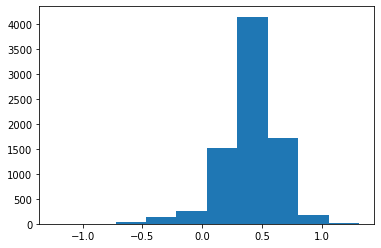

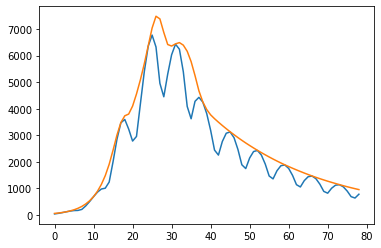

In [4]:
plt.hist(traces[3].offset_modulation)
plt.figure()
plt.plot(np.median(traces[3].new_cases, axis=0))
plt.plot(np.median(traces[3].new_cases_raw, axis=0))

148298.48635868903


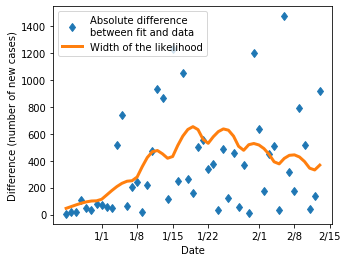

In [5]:
trace = traces[3]
fig, ax = plt.subplots(figsize=(5,4))
time = np.arange(-len(cases_obs)+1, 0)
mpl_dates = conv_time_to_mpl_dates(time) 
ax.plot(mpl_dates, np.abs(np.median(trace.new_cases[:, :num_days_data], axis=0) - np.diff(cases_obs)), 
        'd', markersize=6,
         label='Absolute difference\n'
               'between fit and data')
ax.plot(mpl_dates, np.sqrt(np.median(trace.new_cases[:, :num_days_data], axis=0))*np.median(trace.sigma_obs, axis=0),
         label='Width of the likelihood', lw=3)
ax.set_ylabel('Difference (number of new cases)')
ax.set_xlabel('Date')
ax.legend(loc='upper left')
print(np.median(np.sum(trace.new_cases[:, :num_days_data], axis=1)+ trace.I_begin))
#plt.tight_layout()
ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%-m/%-d'))


In [6]:
exec(open('figures.py').read())

/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:326: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.WeekdayLocator'>


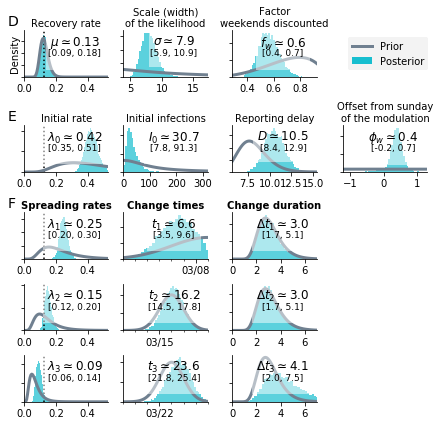

In [7]:
def get_label_dict(version=0):
    labels = dict()
    labels["mu"] = f"Recovery rate $\mu$"
    labels["delay"] = f"Delay $D$"
    labels["I_begin"] = f"Initial infections $I_0$"
    labels["sigma_obs"] = f"Scale $\sigma$\nof the likelihood"
    labels["lambda_0"] = f"Initial\nspreading rate $\lambda_0$"
    if version == 0:
        labels["lambda_1"] = f"Mild distancing\nspreading rate $\lambda_1$"
        labels["lambda_2"] = f"Strong distancing\nspreading rate $\lambda_2$"
        labels["lambda_3"] = f"Contact ban\nspreading rate $\lambda_3$"
        labels["transient_begin_0"] = f"Mild distancing\nstarting time $t_1$"
        labels["transient_begin_1"] = f"Strong distancing\nstarting time $t_2$"
        labels["transient_begin_2"] = f"Contact ban\nstarting time $t_3$"
        labels["transient_len_0"] = f"Mild distancing\ntransient $\Delta t_1$"
        labels["transient_len_1"] = f"Strong distancing\ntransient $\Delta t_2$"
        labels["transient_len_2"] = f"Contact ban\ntransient $\Delta t_3$"
    elif version == 1:
        labels["lambda_1"] = f"Spreading rate $\lambda_1$"
        labels["lambda_2"] = f"Spreading rate $\lambda_2$"
        labels["lambda_3"] = f"Spreading rate $\lambda_3$"
        labels["transient_begin_0"] = f"Starting time $t_1$"
        labels["transient_begin_1"] = f"Starting time $t_2$"
        labels["transient_begin_2"] = f"Starting time $t_3$"
        labels["transient_len_0"] = f"Transient $\Delta t_1$"
        labels["transient_len_1"] = f"Transient $\Delta t_2$"
        labels["transient_len_2"] = f"Transient $\Delta t_3$"
    elif version == 2:
        labels["mu"] = f"Recovery rate"
        labels["delay"] = f"Reporting delay"
        labels["I_begin"] = f"Initial infections"
        labels["sigma_obs"] = f"Scale (width)\nof the likelihood"
        labels["lambda_0"] = f"Initial rate"
        labels["lambda_1"] = f"Spreading rates"
        labels["lambda_2"] = f""
        labels["lambda_3"] = f""
        labels["transient_begin_0"] = f"Change times"
        labels["transient_begin_1"] = f""
        labels["transient_begin_2"] = f""
        labels["transient_len_0"] = f"Change duration"
        labels["transient_len_1"] = f""
        labels["transient_len_2"] = f""
        labels['E_begin_scale'] = 'Initial scale\nof exposed'
        labels['median_incubation'] = 'Median\nincubation delay'
        labels['sigma_random_walk'] = 'Std. of\nrandom walk'
        labels['weekend_factor'] = 'Factor\nweekends discounted'
        labels['offset_modulation_rad'] = 'Offset from sunday\nof the modulation'
    return labels

def create_figure_3_distributions(model, trace, save_to=None, layout=2,
                                  additional_insets=None, xlim_lambda=(0, 0.53), color='tab:green',
                                  num_changepoints=3, xlim_tbegin=4):
    if additional_insets is None:
        additional_insets = {}
    # model = models[3]
    colors = ["#708090", color]
    additional_dists = len(additional_insets)
    if layout == 0:
        fig, axes = plt.subplots(3, 5, figsize=(9, 6))
    elif layout == 1:
        fig, axes = plt.subplots(4, 4, figsize=(6, 6), constrained_layout=True)
    elif layout == 2:
        num_columns = int(np.ceil((additional_dists + 14) / 5))
        num_rows = num_changepoints + 2
        width_col = 4.5 / 3 * num_columns
        height_fig = 6 if not num_changepoints == 1 else 5
        fig, axes = plt.subplots(num_rows, num_columns, figsize=(width_col, 6), constrained_layout=True)

    xlim_transt = (0, 7)
    xlim_tbegin = xlim_tbegin  # median plus minus x days

    axpos = dict()
    letters = dict()
    labels = get_label_dict(version=0)

    # leave away the closing doller, we add it later
    insets = dict()
    insets["lambda_0"] = r"$\lambda_0 \simeq "
    insets["lambda_1"] = r"$\lambda_1 \simeq "
    insets["lambda_2"] = r"$\lambda_2 \simeq "
    insets["lambda_3"] = r"$\lambda_3 \simeq "
    insets["transient_begin_0"] = r"$t_1 \simeq "
    insets["transient_begin_1"] = r"$t_2 \simeq "
    insets["transient_begin_2"] = r"$t_3 \simeq "
    insets["transient_len_0"] = r"$\Delta t_1 \simeq "
    insets["transient_len_1"] = r"$\Delta t_2 \simeq "
    insets["transient_len_2"] = r"$\Delta t_3 \simeq "

    insets["mu"] = r"$\mu \simeq "
    insets["delay"] = r"$D \simeq "
    insets["sigma_obs"] = r"$\sigma \simeq "
    insets["I_begin"] = r"$I_0 \simeq "

    for key, inset in additional_insets.items():
        insets[key] = inset

    if layout == 0:
        pos_letter = (0, 1.08)
        axpos["lambda_0"] = axes[0][0]
        axpos["lambda_1"] = axes[0][1]
        axpos["lambda_2"] = axes[0][2]
        axpos["lambda_3"] = axes[0][3]
        axpos["transient_begin_0"] = axes[1][1]
        axpos["transient_begin_1"] = axes[1][2]
        axpos["transient_begin_2"] = axes[1][3]
        axpos["transient_len_0"] = axes[2][1]
        axpos["transient_len_1"] = axes[2][2]
        axpos["transient_len_2"] = axes[2][3]

        axpos["mu"] = axes[0][4]
        axpos["delay"] = axes[2][4]
        axpos["I_begin"] = axes[1][0]
        axpos["sigma_obs"] = axes[1][4]
        axpos["legend"] = axes[2][0]

        letters["lambda_0"] = "D"
        letters["lambda_1"] = "E1"
        letters["lambda_2"] = "E2"
        letters["lambda_3"] = "E3"
        letters["mu"] = "F"

    elif layout == 1:
        pos_letter = (-0.3, 1.1)
        labels = get_label_dict(version=2)
        axpos["lambda_0"] = axes[0][0]
        axpos["lambda_1"] = axes[0][1]
        axpos["lambda_2"] = axes[0][2]
        axpos["lambda_3"] = axes[0][3]
        axpos["transient_begin_0"] = axes[1][1]
        axpos["transient_begin_1"] = axes[1][2]
        axpos["transient_begin_2"] = axes[1][3]
        axpos["transient_len_0"] = axes[2][1]
        axpos["transient_len_1"] = axes[2][2]
        axpos["transient_len_2"] = axes[2][3]

        axpos["mu"] = axes[3][0]
        axpos["delay"] = axes[3][1]
        axpos["I_begin"] = axes[3][2]
        axpos["sigma_obs"] = axes[3][3]
        axpos["legend"] = axes[2][0]

        axes[1][0].axis("off")

        letters["lambda_0"] = "D"
        letters["lambda_1"] = "E1"
        letters["lambda_2"] = "E2"
        letters["lambda_3"] = "E3"
        # letters["mu"] = "F"

    elif layout == 2:
        pos_letter = (-0.2, 1.1)
        labels = get_label_dict(version=2)
        axpos["lambda_0"] = axes[1][0]
        for i_cp in range(0, num_changepoints):
            axpos["lambda_{}".format(i_cp + 1)] = axes[i_cp + 2][0]
            axpos["transient_begin_{}".format(i_cp)] = axes[i_cp + 2][1]
            axpos["transient_len_{}".format(i_cp)] = axes[i_cp + 2][2]

        axpos["mu"] = axes[0][0]
        axpos["delay"] = axes[1][2]
        axpos["I_begin"] = axes[1][1]
        axpos["sigma_obs"] = axes[0][1]

        letters["lambda_0"] = r"E"
        letters["lambda_1"] = r"F"
        # letters["lambda_2"] = r"F2"
        # letters["lambda_3"] = r"F3"
        letters["mu"] = r"D"
        # letters["sigma_obs"] = "G"
        # letters["delay"] = "H"
        i  = num_rows-1
        for i, (key, inset) in enumerate(additional_insets.items()):
            col = int(np.floor((i + 14) / num_rows))
            row = i % num_rows
            axpos[key] = axes[row][col]
        for i in range(i + 1, num_rows):
            axes[i][col].set_visible(False)
        if not len(additional_insets) % num_rows == 1:
            axpos["legend"] = axes[0][num_columns - 1]

    for key in axpos.keys():
        axpos[key].xaxis.set_label_position("top")

    # render panels
    for key in axpos.keys():
        if "legend" in key:
            continue

        if "transient_begin" in key:
            data = conv_time_to_mpl_dates(trace[key])
        else:
            data = trace[key]
        if 'weekend_factor_rad' == key:
            data = data/np.pi/2*7

        ax = axpos[key]
        ax.set_xlabel(labels[key])

        # make some bold
        if layout == 2 and (
                key == "lambda_1" or key == "transient_begin_0" or key == "transient_len_0"
        ):
            ax.set_xlabel(labels[key], fontweight="bold")

        # posteriors
        ax.hist(
            data,
            bins=50,
            density=True,
            color=colors[1],
            label="Posterior",
            alpha=0.7,
            zorder=-5,
        )

        # xlim
        if "lambda" in key or "mu" == key:
            ax.set_xlim(xlim_lambda)
            ax.axvline(np.median(trace["mu"]), ls=":", color="black")
        elif "I_begin" == key:
            ax.set_xlim(0)
        elif "transient_len" in key:
            ax.set_xlim(xlim_transt)
        elif "transient_begin" in key:
            md = np.median(data)
            ax.set_xlim([int(md) - xlim_tbegin, int(md) + xlim_tbegin - 1])
            format_date_xticks(ax)

        # priors
        limits = ax.get_xlim()
        x = np.linspace(*limits, num=100)
        if 'transient_begin' in key:
            beg_x = matplotlib.dates.num2date(x[0])
            diff_dates_x = (beg_x.replace(tzinfo=None) - date_begin_sim).days
            x_input = x - x[0] + diff_dates_x
        else:
            x_input = x
        if 'weekend_factor_rad' == key:
            x *=np.pi*2/7
        ax.plot(
            x,
            # priors[key](x),
            cov19.plotting.get_prior_distribution(model, x_input, key),
            label="Prior",
            color=colors[0],
            linewidth=3,
        )
        ax.set_xlim(*limits)

        # letters
        if key in letters.keys():
            ax.text(
                pos_letter[0],
                pos_letter[1],
                letters[key],
                transform=ax.transAxes,
                size=14,
                horizontalalignment="left",
            )

        # median
        global text
        if "lambda" in key or "mu" == key or 'sigma_random_walk' == key:
            text = print_median_CI(data, prec=2)
        elif "transient_begin" in key:
            text = print_median_CI(
                data - matplotlib.dates.date2num(date_data_begin) + 1, prec=1
            )
        else:
            text = print_median_CI(data, prec=1)

        if False:
            ax.text(
                0.05,
                0.9,
                text,
                horizontalalignment="center",
                verticalalignment="top",
                transform=ax.transAxes,
                bbox=dict(facecolor="white", alpha=0.3, edgecolor="none"),
                fontsize=12,
            )
        else:
            if key in insets.keys():
                # strip everything except the median value
                text = text.replace("Median: ", "").replace("CI: ", "")
                md = text.split("\n")[0]
                ci = text.split("\n")[1]

                # matplotlib.rcParams['text.usetex'] = True
                # with rc_context(rc={'text.usetex': True}):
                text = insets[key] + md + "$" + "\n" + r'$\,$'
                ax.text(
                    0.6, 0.9, text, fontsize=12, transform=ax.transAxes,
                    verticalalignment="top",
                    horizontalalignment="center",
                    bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"),
                )
                ax.text(
                    0.6, 0.6, ci, fontsize=9, transform=ax.transAxes,
                    verticalalignment="top",
                    horizontalalignment="center",
                    # bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"),
                ),

    # legend
    if 'legend' in axpos:
        ax = axpos["legend"]
        ax.set_axis_off()
        ax.plot([], [], color=colors[0], linewidth=3, label="Prior")
        ax.hist([], color=colors[1], label="Posterior")
        ax.legend(loc="center left")
        ax.get_legend().get_frame().set_linewidth(0.0)
        ax.get_legend().get_frame().set_facecolor("#F0F0F0")

    # dirty hack to get some space at the bottom to align with timeseries
    if not num_changepoints == 1:
        axes[-1][0].xaxis.set_label_position("bottom")
        axes[-1][0].set_xlabel(r"$\,$")

    for jdx, ax_row in enumerate(axes):
        for idx, ax in enumerate(ax_row):
            if idx == 0 and jdx == 0:
                ax.set_ylabel("Density")
            ax.tick_params(labelleft=False)
            ax.locator_params(nbins=4)
            ax.set_rasterization_zorder(rasterization_zorder)
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)

    # plt.subplots_adjust(wspace=0.2, hspace=0.9)

    if save_to is not None:
        plt.savefig(save_to + ".pdf", bbox_inches="tight", pad_inches=0, dpi=300)
        plt.savefig(save_to + ".png", bbox_inches="tight", pad_inches=0, dpi=300)

create_figure_3_distributions(models[3], traces[3],additional_insets = {'weekend_factor': r"$f_w \simeq ",
                                                   'offset_modulation_rad': r"$\phi_{w} \simeq "},
                              color = 'tab:cyan',  save_to=path_to_save + 'Fig_distr_sine_weekend')

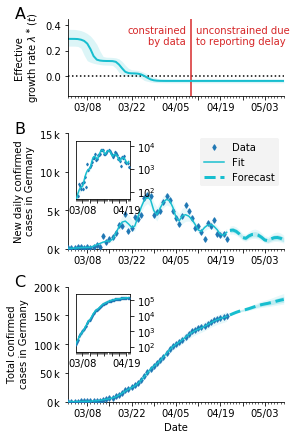

In [8]:
create_figure_timeserie(traces[3], 'tab:cyan',
                       plot_red_axis=True, save_to=path_to_save + 'Fig_cases_sine_weekend')

In [9]:
print('\n0 step model\n')
print(pm.loo(traces[0], model))

print('\n1 step model\n')
print(pm.loo(traces[1], model))

print('\n2 steps model\n')
print(pm.loo(traces[2], model))

print('\n3 steps model\n')
print(pm.loo(traces[3], model))


0 step model

Computed from 8000 by 51 log-likelihood matrix

       Estimate       SE
IC_loo   928.08     9.62
p_loo      6.78        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       50   98.0%
 (0.5, 0.7]   (ok)          1    2.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


1 step model

Computed from 8000 by 51 log-likelihood matrix

       Estimate       SE
IC_loo   821.15    15.50
p_loo     13.26        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       49   96.1%
 (0.5, 0.7]   (ok)          2    3.9%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


2 steps model

Computed from 8000 by 51 log-likelihood matrix

       Estimate       SE
IC_loo   796.49    16.97
p_loo     12.61        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       50   98.0%
 (0.5, 0.7]   (ok) 